In [1725]:
import pandas as pd
import random
import numpy as np
import statistics
from matplotlib import pyplot as plt
from keras.models import Model
from keras.layers import Dense, Input
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras import initializers
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [871]:
file = "../../../data/warfarin.csv"
df = pd.read_csv(file)
df.head(5)

,ID,TIME,WEIGHT,AGE,SEX,CMT,AMT,DVID,DV,MDV,MDVPK
0,100,0.0,66.7,50,1,1,100.0,1,NaN,1,1
1,100,0.5,66.7,50,1,2,NaN,1,0.0,0,0
2,100,1.0,66.7,50,1,2,NaN,1,1.9,0,0
3,100,2.0,66.7,50,1,2,NaN,1,3.3,0,0
4,100,3.0,66.7,50,1,2,NaN,1,6.6,0,0


In [872]:
# Forward fill AMT for each patient. Then delete dose obervation
df['AMT'] = df['AMT'].ffill()
df = df[~df['DV'].isnull()]

In [873]:
# Divide datasets: when DVID = 1, we have data for PK and when DVID = 2, we have data for PD
df_pk = df[(df.DVID == 1)]
df_pd = df[(df.DVID == 2)]

In [874]:
# Select columns
df_pk = df_pk[["ID", "TIME", "WEIGHT", "AGE", "SEX", "AMT", "DV"]]

In [1049]:
# Only keep values where DV is larger than 0
df_pk = df_pk[df_pk['DV']>0]

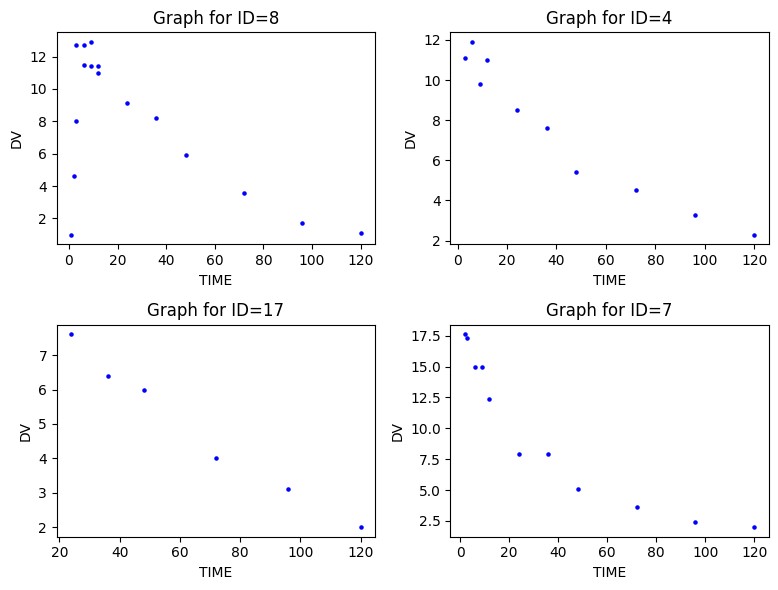

In [1050]:
# Graph 4 random patients
subjects = list(df_pk['ID'].unique())
fig, ax = plt.subplots(2,2,figsize=(8,6))
ax = ax.ravel()
random.seed(1)
for ix, i in enumerate(random.sample(subjects, 4)):
    df_subject = df_pk[(df_pk['ID'] == i)]
    df_subject.plot(kind = 'scatter', ax = ax[ix], x = 'TIME', y = 'DV', color = 'blue', s=5)
    ax[ix].set_title(f'Graph for ID={i}')

plt.tight_layout()

In [1430]:
# Column order requirement
def column_order():
    return ['TIME', 'WEIGHT', 'AGE', 'SEX', 'AMT']

In [1846]:
def normalize_df(X_train, X_test=None, col_abs = ['WEIGHT', 'AGE', 'AMT'], col_std = []):
    # Standardize and normalize data
    scaler = ColumnTransformer([
                            ('max_abs_scaler', MaxAbsScaler(), col_abs),
                            ('std_scaler', StandardScaler(), col_std)
                            ], 
                        remainder='passthrough')
    X_train = scaler.fit_transform(X_train)
    if X_test is not None:
        X_test = scaler.transform(X_test)
    
    return X_train, X_test, scaler

In [1847]:
# Neural Network Builder
def dnn(input_shape):
    initializer = initializers.RandomNormal(mean=0.0, stddev=1.0)
    
    ## Build model
    X_input = Input(shape = (input_shape,))
    
    X = Dense(8, 
              activation='swish', 
              kernel_initializer=initializer,
              bias_initializer='zeros')(X_input)
    
    X = Dense(4, activation='swish',
              kernel_initializer=initializer,
              bias_initializer='zeros')(X)
    
    X = Dense(1,
              activation='softplus',
              kernel_initializer=initializer,
              bias_initializer='zeros')(X)
    
    # Define model
    model = Model(inputs = X_input, outputs = X)
    
    return model

In [1884]:
def lr_scheduler(epoch):
    if epoch < 300:
        return 1e-2
    else:
        return 1e-3

In [1885]:
# Train a model
def train_model(model, opt, X_train, y_train, X_test, y_test, epochs=500, plot=True):
  if X_test is None:
    X_test = []
  
  model.compile(loss='mean_squared_error', optimizer=opt, metrics=["mean_absolute_error"])
  
  history = model.fit(X_train, 
            y_train,
            epochs=epochs,
            validation_data = (X_test, y_test) if len(X_test)>0 else None,
            verbose = 0,
            #batch_size = 32,
            callbacks = [LearningRateScheduler(lr_scheduler, verbose=0),
                         #EarlyStopping(patience = 100,  min_delta = 1e-3, restore_best_weights = True, monitor = 'loss')
                         ]
            )

  if plot:
    plt.figure(figsize = (8,4))
    plt.plot(history.history['mean_absolute_error'], label = 'Train MAE')
    if len(X_test)>0:
      plt.plot(history.history['val_mean_absolute_error'], label = 'Test MAE')
    plt.legend(loc = 'best');
    plt.xlabel('Epochs');
    plt.ylabel('MAE');
    plt.title('MAE')
    plt.show()
  
  return model, history.history

In [1886]:
# Training via K folds
# The dataset is randomly split 75-25 and the model is trained. This is done folds times
def kfolds_training(df, epochs = 500, folds = 5, col_abs = ['WEIGHT', 'AGE', 'AMT'], col_std = [], plot=True):
    cols = column_order()

    subjects = list(df['ID'].unique())
    
    mae_train = []
    mae_test = []
    
    count_folds = 0
    iter = 0
    while count_folds < folds and iter < folds*2:
        # 25% of subjects go to test 
        test_subjects = random.sample(subjects, int(len(subjects)/4))
        data_train = df[~df['ID'].isin(test_subjects)]
        data_test = df[df['ID'].isin(test_subjects)]
        
        # Train and test splits
        X_train = data_train[cols]
        y_train = data_train['DV'].values

        X_test = data_test[cols]
        y_test = data_test['DV'].values
        
        # Normalize df
        X_train, X_test, scaler = normalize_df(X_train, X_test, col_abs = col_abs, col_std = [])
        
        # Build model
        model = dnn(X_train.shape[1])
        opt = Adam(learning_rate=1e-3)
        
        # Train model
        model, history = train_model(model, opt, X_train, y_train, X_test, y_test, epochs=epochs, plot=plot)
        
        # Only count if the model trains and is not stuck because of the random initial values
        if len(history['loss']) > 10+1:
            count_folds += 1
            mae_train.append(model.evaluate(X_train, y_train, return_dict = True)['mean_absolute_error'])
            mae_test.append(model.evaluate(X_test, y_test, return_dict = True)['mean_absolute_error'])
        
        iter += 1
    
    print(f'Number of iterations: {iter}') 
    print(f'Number of folds: {count_folds}') 
    return mae_train, mae_test, model, scaler

In [1887]:
# Full training using all data
def full_training(df, epochs = 500):
    cols = column_order()
    
    X = df[cols]
    y = df['DV'].values
    
    X, _, scaler = normalize_df(X, X_test=None, col_abs = ['WEIGHT', 'AGE', 'AMT'], col_std = [])

    opt = Adam(learning_rate=1e-3)
    model = dnn(X.shape[1])
    model, history = train_model(model, opt, X, y, None, None, epochs=epochs, plot=True)
    
    return model, history, scaler

In [1888]:
df2 = df_pk.copy()

# Artificially add (AMT, DV) = (0,0) for all times to force DV = 0 when AMT = 0
#df_zeros = df2.copy()
#df_zeros.loc[:, ['AMT', 'DV']] = [0,0]
#df2 = pd.concat([df2, df_zeros])

# Artificially add (TIME, DV) = (0,0) to force DV = 0 at TIME = 0
#df_zeros = df2.drop_duplicates(subset = ['ID'])
#df_zeros.loc[:, ['TIME', 'DV']] = [0,0]
#df2 = pd.concat([df2, df_zeros])

df2.head(5)

,ID,TIME,WEIGHT,AGE,SEX,AMT,DV
2,100,1.0,66.7,50,1,100.0,1.9
3,100,2.0,66.7,50,1,100.0,3.3
4,100,3.0,66.7,50,1,100.0,6.6
5,100,6.0,66.7,50,1,100.0,9.1
6,100,9.0,66.7,50,1,100.0,10.8


In [1890]:
epochs = 1500
folds = 5

mae_train, mae_test, model, scaler = kfolds_training(df = df2, epochs = epochs, folds=folds, 
                                                 col_abs = ['WEIGHT', 'AGE', 'AMT'], plot=False)
print('Mean MAE across all folds - Train: {:.2f}'.format(statistics.mean(mae_train)))
print('Mean MAE across all folds - Test: {:.2f}'.format(statistics.mean(mae_test)))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.4736 - mean_absolute_error: 1.1791 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.7744 - mean_absolute_error: 1.5670 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 2.8301 - mean_absolute_error: 1.2169
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4336 - mean_absolute_error: 0.9984 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - loss: 1.8165 - mean_absolute_error: 1.0678
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - loss: 4.9753 - mean_absolute_error: 1.5830
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - loss: 2.2615 - mean_absolute_error: 1.1576
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.8735 - mean_absolute_error: 1.5797
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - loss: 1.6255 - mean_absolute_error: 1.0077
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3357 - mean_absolute_error: 1.3910
Number of iterations: 5
Number of folds: 5
Mean MAE across all folds - Train: 1.00
Mean MAE across all folds - Test: 1.30


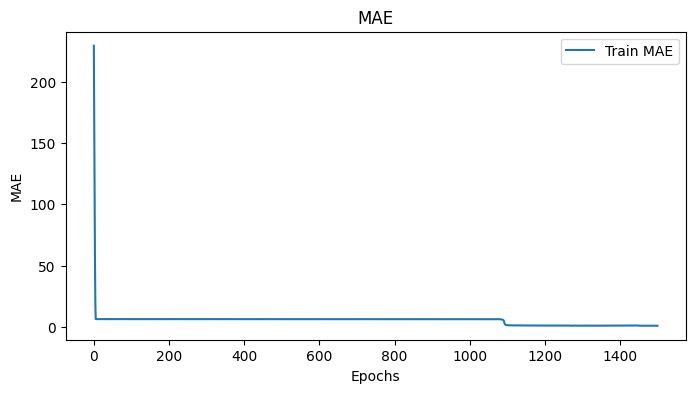

Final MAE: 1.13


In [1891]:
model, history, scaler = full_training(df2, epochs=epochs)
print('Final MAE: {:.2f}'.format(history['mean_absolute_error'][-1]))

In [1957]:
def predict_patient(df, model, scaler, max_time = 120, patient_id=None, plot=True, plot_true_labels = True):
    cols = column_order()
    time = np.arange(0,int(max_time))
    df_predicted = pd.DataFrame({'TIME': time,
                        'WEIGHT': [df['WEIGHT'].values[0]] * len(time),
                        'AGE': [df['AGE'].values[0]] * len(time), 
                        'SEX': [df['SEX'].values[0]] * len(time),
                        'AMT': [df['AMT'].values[0]] * len(time)}
                    )
    
    X_predicted = scaler.transform(df_predicted[cols])
    predicted = model.predict(X_predicted)

    df_predicted = pd.DataFrame({'TIME': time, 'predicted': predicted.flatten()})

    if plot:
        fig, ax = plt.subplots(1,1,figsize=(6,3))
        if plot_true_labels:
            df.plot(kind = 'line', ax = ax, x = 'TIME', y = 'DV', linewidth=0.5, color = 'blue', style='--o', markersize=3, label='Real')
        df_predicted.plot(kind = 'line', ax = ax, x = 'TIME', y = 'predicted', linewidth=1, color = 'black', style='-', label='Predicted')
        ax.set_title(f'Graph for ID={patient_id}')
        ax.set_ylabel('Concentration')
        plt.legend(loc='best')
    
    return df_predicted


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step


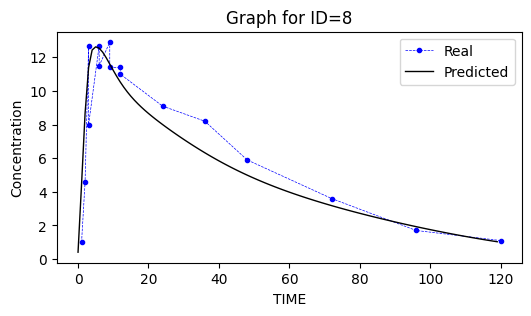

In [1951]:
# Plot random patient and predictions

#random.seed(1)
example = random.choice(subjects)
example = 8
df_subject = df2[df2['ID'] == example]

# Remove fake data (DV=0 and TIME=0 were artificially added to force that prediction)
df_subject = df_subject[~((df_subject['DV'] == 0)&(df_subject['TIME'] == 0))]
df_subject = df_subject[~((df_subject['DV'] == 0)&(df_subject['AMT'] == 0))]

# Predict
df_predicted = predict_patient(df_subject, model, scaler, patient_id=example, plot=True, plot_true_labels=True)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step


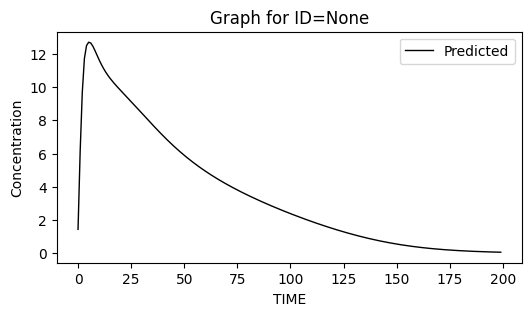

In [2037]:
df_test = pd.DataFrame(data = {'WEIGHT': 100, 
                                'AGE': 20,
                                'SEX': 1,
                                'AMT': 100},
                        index = [0])
_ = predict_patient(df_test, model, scaler, max_time = 200, plot=True, plot_true_labels=False)

In [1910]:
def test_variables(df_subject, model, scaler, max_time = 120, variable = 'AMT', values = [0, 1, 10, 50, 100, 200, 500],  savefile = None):
    
    d = df_subject.copy()
    
    color = iter(plt.cm.cividis(np.linspace(0, 1, len(values))))
    fig, ax = plt.subplots(1,1,figsize=(6,3), layout='constrained' )
    for i in values:
        d[variable] = i
        df_predicted = predict_patient(d, model, scaler, max_time = max_time, plot=False)
        df_predicted.plot(kind = 'line', ax = ax, x = 'TIME', y = 'predicted', linewidth=1, color = next(color), style='-', label=f'{variable}={i}')
        ax.set_ylabel('Concentration')
        ax.set_xlabel('Time')
        plt.legend(prop={'size': 8}, bbox_to_anchor=(1.05, 1.05), ncol=1, facecolor='white', framealpha=1)
    
    if savefile:
        fig.savefig(savefile)
        
    

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step


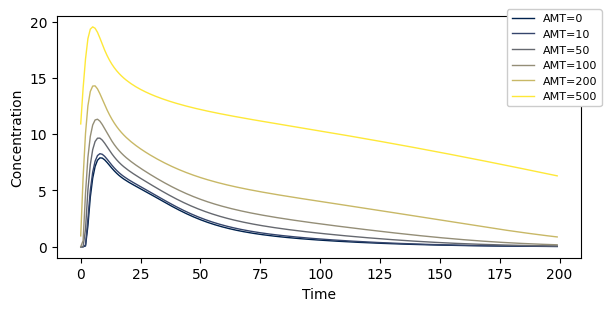

In [1912]:
test_variables(df_subject, model, scaler, max_time = 200, 
               variable = 'AMT', 
               values = [0, 10, 50, 100, 200, 500], 
               savefile = None)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


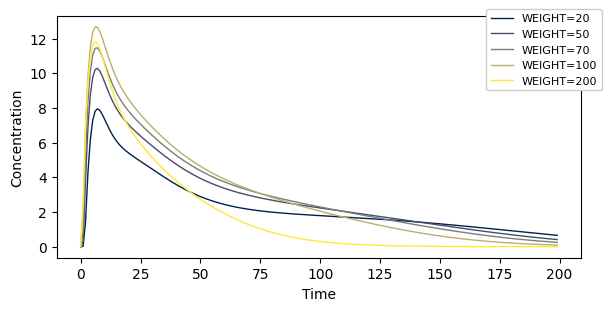

In [1913]:
test_variables(df_subject, model, scaler, max_time = 200, 
               variable = 'WEIGHT', 
               values = [20, 50, 70, 100, 200], 
               savefile = None)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step


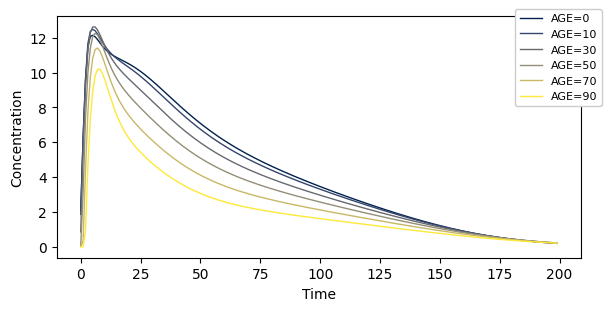

In [1914]:
test_variables(df_subject, model, scaler, max_time = 200, 
               variable = 'AGE', 
               values = [0, 10, 30, 50, 70, 90], 
               savefile = None)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step


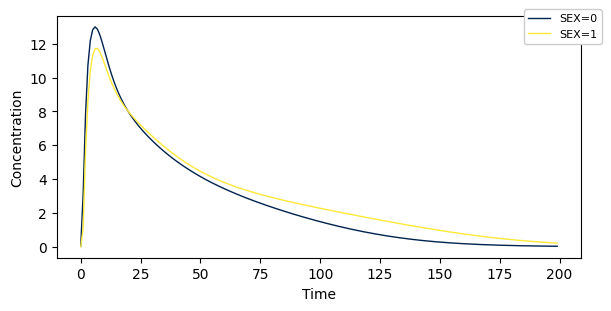

In [1915]:
test_variables(df_subject, model, scaler, max_time = 200, 
               variable = 'SEX', 
               values = [0, 1], 
               savefile = None)

In [2024]:
# Multiple doses (add curves)
def multiple_doses(df_test, time_simulation, time_new_dose = [], new_dose = []):
        # Initial dose
        df_predicted = predict_patient(df_test, model, scaler, max_time = time_simulation, 
                                plot=False, plot_true_labels=False)

        for ix, dose in enumerate(new_dose):
                # New dose
                df_test['AMT'] = dose
                                
                df_predicted_redose = predict_patient(df_test, model, scaler, max_time = time_simulation - time_new_dose[ix],
                                        plot=False, plot_true_labels=False)
                df_predicted_redose['TIME'] += time_new_dose[ix]
                df_predicted = df_predicted.merge(df_predicted_redose, how = 'left', on='TIME')
                df_predicted = df_predicted.fillna({'predicted_y':0})
                df_predicted['predicted'] = df_predicted['predicted_x'] + df_predicted['predicted_y']
                df_predicted = df_predicted.drop(columns = ['predicted_x', 'predicted_y'])
                
        fig, ax = plt.subplots(1,1,figsize=(6,3))
        df_predicted.plot(kind = 'line', ax = ax, x = 'TIME', y = 'predicted', linewidth=1, color = 'black', style='-', label='Predicted')
        ax.set_ylabel('Concentration')
        plt.legend(loc='best')

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


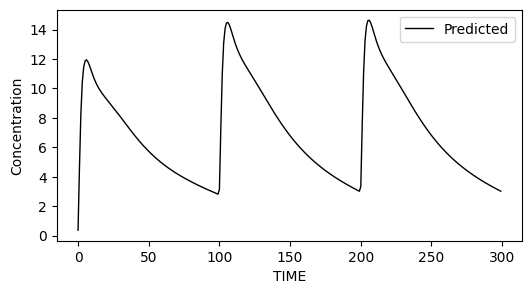

In [2031]:
df_test = pd.DataFrame(data = {'WEIGHT': 70, 
                                'AGE': 30,
                                'SEX': 1,
                                'AMT': 100},
                        index = [0])

multiple_doses(df_test, 300, time_new_dose = [100, 200], new_dose = [100, 100])
